In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import torch
from torchvision import transforms
from torchvision import datasets
import pandas as pd
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision.datasets import ImageFolder
import numpy as np

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
#Transforms
train_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-10, +10)),
    # transforms.TrivialAugmentWide(num_magnitude_bins=5),
    transforms.ToTensor()
])

valid_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])


test_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [5]:
# Directories for train, valid, test datasets
train_dir="/content/drive/MyDrive/bird_dataset/train"
valid_dir="/content/drive/MyDrive/bird_dataset/valid"
test_dir="/content/drive/MyDrive/bird_dataset/test"
data_train=ImageFolder(train_dir, train_transform)
data_valid=ImageFolder(valid_dir, valid_transform)
data_test=ImageFolder(test_dir, test_transform)

In [6]:
data_train.class_to_idx

{'ALBATROSS': 0,
 'AMERICAN AVOCET': 1,
 'BLACK SWAN': 2,
 'CACTUS WREN': 3,
 'CHINESE BAMBOO PARTRIDGE': 4,
 'COMMON STARLING': 5,
 'CUBAN TROGON': 6,
 'GREAT ARGUS': 7,
 'JAVA SPARROW': 8,
 'PUFFIN': 9,
 'WILD TURKEY': 10,
 'ZEBRA DOVE': 11}

In [7]:
train_loader=DataLoader(data_train, batch_size=16, shuffle=True)
valid_loader=DataLoader(data_valid, batch_size=16)
test_loader=DataLoader(data_test)

In [8]:
len(train_loader)

121

In [9]:
class Resnet50(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=0)
    self.pool=nn.MaxPool2d(kernel_size=3, stride=2)
    self.bottleneck11=nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(64),
                                    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding="same"),
                                    nn.BatchNorm2d(64),
                                    nn.Conv2d(in_channels=64, out_channels=256, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU()
                                    )
    self.down1=nn.Sequential(nn.Conv2d(in_channels=64, out_channels=256, kernel_size=1, stride=1),
                             nn.BatchNorm2d(256))
    self.bottleneck12=nn.Sequential(nn.Conv2d(in_channels=256, out_channels=64, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(64),
                                    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding="same"),
                                    nn.BatchNorm2d(64),
                                    nn.Conv2d(in_channels=64, out_channels=256, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU()
                                    )
    self.bottleneck13=nn.Sequential(nn.Conv2d(in_channels=256, out_channels=64, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(64),
                                    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding="same"),
                                    nn.BatchNorm2d(64),
                                    nn.Conv2d(in_channels=64, out_channels=256, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU()
                                    )
    self.bottleneck21=nn.Sequential(nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(128),
                                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.Conv2d(in_channels=128, out_channels=512, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU()
                                    )
    self.down2=nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1, stride=2),
                             nn.BatchNorm2d(512))
    self.bottleneck22=nn.Sequential(nn.Conv2d(in_channels=512, out_channels=128, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(128),
                                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding="same"),
                                    nn.BatchNorm2d(128),
                                    nn.Conv2d(in_channels=128, out_channels=512, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU()
                                    )
    self.bottleneck23=nn.Sequential(nn.Conv2d(in_channels=512, out_channels=128, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(128),
                                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding="same"),
                                    nn.BatchNorm2d(128),
                                    nn.Conv2d(in_channels=128, out_channels=512, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU()
                                    )
    self.bottleneck24=nn.Sequential(nn.Conv2d(in_channels=512, out_channels=128, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(128),
                                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding="same"),
                                    nn.BatchNorm2d(128),
                                    nn.Conv2d(in_channels=128, out_channels=512, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU()
                                    )
    self.bottleneck31=nn.Sequential(nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(256),
                                    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1),
                                    nn.BatchNorm2d(256),
                                    nn.Conv2d(in_channels=256, out_channels=1024, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(1024),
                                    nn.ReLU()
                                    )
    self.down3=nn.Sequential(nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1, stride=2),
                             nn.BatchNorm2d(1024))
    self.bottleneck32=nn.Sequential(nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(256),
                                    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding="same"),
                                    nn.BatchNorm2d(256),
                                    nn.Conv2d(in_channels=256, out_channels=1024, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(1024),
                                    nn.ReLU()
                                    )
    self.bottleneck33=nn.Sequential(nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(256),
                                    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding="same"),
                                    nn.BatchNorm2d(256),
                                    nn.Conv2d(in_channels=256, out_channels=1024, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(1024),
                                    nn.ReLU()
                                    )
    self.bottleneck34=nn.Sequential(nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(256),
                                    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding="same"),
                                    nn.BatchNorm2d(256),
                                    nn.Conv2d(in_channels=256, out_channels=1024, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(1024),
                                    nn.ReLU()
                                    )
    self.bottleneck35=nn.Sequential(nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(256),
                                    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding="same"),
                                    nn.BatchNorm2d(256),
                                    nn.Conv2d(in_channels=256, out_channels=1024, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(1024),
                                    nn.ReLU()
                                    )
    self.bottleneck36=nn.Sequential(nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(256),
                                    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding="same"),
                                    nn.BatchNorm2d(256),
                                    nn.Conv2d(in_channels=256, out_channels=1024, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(1024),
                                    nn.ReLU()
                                    )
    self.bottleneck41=nn.Sequential(nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(512),
                                    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1),
                                    nn.BatchNorm2d(512),
                                    nn.Conv2d(in_channels=512, out_channels=2048, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(2048),
                                    nn.ReLU()
                                    )
    self.down4=nn.Sequential(nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=1, stride=2),
                             nn.BatchNorm2d(2048))
    self.bottleneck42=nn.Sequential(nn.Conv2d(in_channels=2048, out_channels=512, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(512),
                                    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding="same"),
                                    nn.BatchNorm2d(512),
                                    nn.Conv2d(in_channels=512, out_channels=2048, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(2048),
                                    nn.ReLU()
                                    )
    self.bottleneck43=nn.Sequential(nn.Conv2d(in_channels=2048, out_channels=512, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(512),
                                    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding="same"),
                                    nn.BatchNorm2d(512),
                                    nn.Conv2d(in_channels=512, out_channels=2048, kernel_size=1, stride=1, padding="same"),
                                    nn.BatchNorm2d(2048),
                                    nn.ReLU()
                                    )
    self.last=nn.Sequential(nn.AdaptiveAvgPool2d(output_size=(1, 1)),
                            nn.Flatten(),
                            nn.Linear(2048, 12))

  def forward(self, x):
    x=self.pool(self.conv1(x))
    x=self.bottleneck11(x)+self.down1(x)
    x=x+self.bottleneck12(x)
    x=x+self.bottleneck13(x)
    x=self.bottleneck21(x)+self.down2(x)
    x=x+self.bottleneck22(x)
    x=x+self.bottleneck23(x)
    x=x+self.bottleneck24(x)
    x=self.bottleneck31(x)+self.down3(x)
    x=x+self.bottleneck32(x)
    x=x+self.bottleneck33(x)
    x=x+self.bottleneck34(x)
    x=x+self.bottleneck35(x)
    x=x+self.bottleneck36(x)
    x=self.bottleneck41(x)+self.down4(x)
    x=x+self.bottleneck42(x)
    x=x+self.bottleneck43(x)

    return self.last(x)








In [10]:
from torch import optim
model1=Resnet50().to(device)
losss=nn.CrossEntropyLoss()
model_optim=optim.Adam(model1.parameters(), lr=1e-4) #Optimizer and loss functions can be changed

In [11]:
model1

Resnet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck11): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
  )
  (down1): Sequential(
    (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bottleneck12): Sequential(
    (0): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, e

In [ ]:
#Accuracy function
def multiclass_accuracy(y_pred,y_true):
  top_p,top_class = y_pred.topk(1,dim = 1)
  equals = top_class == y_true.view(*top_class.shape)
  return torch.mean(equals.type(torch.FloatTensor))

In [ ]:
# train function
from tqdm import tqdm
def train(model, trainloader, optimizer, loss_func):
  total_loss=0
  total_accuracy=0
  model.train()
  for i, data in enumerate(tqdm(trainloader)):
    image, label= data
    image=image.to(device)
    label=label.to(device)
    optimizer.zero_grad()
    pred=model(image)
    loss=loss_func(pred, label)
    total_loss+=loss.item()
    loss.backward()
    optimizer.step()
    accuracy=multiclass_accuracy(pred, label)
    total_accuracy+=accuracy
  return total_loss/len(trainloader), total_accuracy/len(trainloader)


In [ ]:
#Eval function
def evall(model, loader, loss_func):
  total_loss=0
  total_accuracy=0
  model.eval()
  for i, data in enumerate(tqdm(loader)):
    image, label= data
    image=image.to(device)
    label=label.to(device)
    pred=model(image)
    loss=loss_func(pred, label)
    total_loss+=loss.item()
    accuracy=multiclass_accuracy(pred, label)
    total_accuracy+=accuracy
  return total_loss/len(loader), total_accuracy/len(loader)

In [ ]:
#Training the model
from torch import optim
best_loss=np.Inf
train_losss=[]
valid_losss=[]
for i in range(10):
  train_loss, train_accuracy=train(model1, train_loader, model_optim, losss)
  print(f"Current epoch:{i},  train loss:{train_loss},  train accuracy:{train_accuracy}")
  train_losss.append(train_loss)
  valid_loss, valid_accuracy=evall(model1, valid_loader, losss)
  print(f"Current epoch:{i},  valid loss:{valid_loss},  valid accuracy:{valid_accuracy}")
  valid_losss.append(valid_loss)
  if valid_loss < best_loss:
    torch.save(model1.state_dict(), "/content/drive/MyDrive/classification_models/best_model_resnet.pt")
    best_loss=valid_loss




100%|██████████| 121/121 [15:17<00:00,  7.58s/it]


Current epoch:0,  train loss:1.8267873166021236,  train accuracy:0.40203166007995605


100%|██████████| 4/4 [00:27<00:00,  6.96s/it]


Current epoch:0,  valid loss:1.7164196819067001,  valid accuracy:0.5052083134651184


100%|██████████| 121/121 [00:25<00:00,  4.77it/s]


Current epoch:1,  train loss:1.1374064550912084,  train accuracy:0.6336088180541992


100%|██████████| 4/4 [00:00<00:00, 12.52it/s]


Current epoch:1,  valid loss:1.134137898683548,  valid accuracy:0.6145833134651184


100%|██████████| 121/121 [00:25<00:00,  4.75it/s]


Current epoch:2,  train loss:0.9285141030126367,  train accuracy:0.6995523571968079


100%|██████████| 4/4 [00:00<00:00, 12.04it/s]


Current epoch:2,  valid loss:0.70672507584095,  valid accuracy:0.7447916865348816


100%|██████████| 121/121 [00:25<00:00,  4.70it/s]


Current epoch:3,  train loss:0.6866722987456755,  train accuracy:0.7746211886405945


100%|██████████| 4/4 [00:00<00:00, 12.30it/s]


Current epoch:3,  valid loss:0.9545501247048378,  valid accuracy:0.7447916865348816


100%|██████████| 121/121 [00:25<00:00,  4.76it/s]


Current epoch:4,  train loss:0.5850175737349455,  train accuracy:0.8100895285606384


100%|██████████| 4/4 [00:00<00:00, 12.32it/s]


Current epoch:4,  valid loss:1.2763862907886505,  valid accuracy:0.609375


100%|██████████| 121/121 [00:25<00:00,  4.74it/s]


Current epoch:5,  train loss:0.5100420427716468,  train accuracy:0.821969747543335


100%|██████████| 4/4 [00:00<00:00, 12.31it/s]


Current epoch:5,  valid loss:1.2005533799529076,  valid accuracy:0.7083333134651184


100%|██████████| 121/121 [00:25<00:00,  4.69it/s]


Current epoch:6,  train loss:0.4834055937210883,  train accuracy:0.8386707901954651


100%|██████████| 4/4 [00:00<00:00, 12.34it/s]


Current epoch:6,  valid loss:0.9954808801412582,  valid accuracy:0.7604166865348816


100%|██████████| 121/121 [00:25<00:00,  4.73it/s]


Current epoch:7,  train loss:0.4572225886681848,  train accuracy:0.852617084980011


100%|██████████| 4/4 [00:00<00:00, 12.59it/s]


Current epoch:7,  valid loss:0.592417698353529,  valid accuracy:0.859375


100%|██████████| 121/121 [00:28<00:00,  4.32it/s]


Current epoch:8,  train loss:0.37069299189019794,  train accuracy:0.8820592164993286


100%|██████████| 4/4 [00:00<00:00, 12.58it/s]


Current epoch:8,  valid loss:1.0936876684427261,  valid accuracy:0.78125


100%|██████████| 121/121 [00:25<00:00,  4.76it/s]


Current epoch:9,  train loss:0.362071807411584,  train accuracy:0.8836088180541992


100%|██████████| 4/4 [00:00<00:00, 12.55it/s]

Current epoch:9,  valid loss:0.857240092009306,  valid accuracy:0.84375


In [ ]:
def loss_curve(epochs, train_losss, valid_losss):
  epochs = list(range(1, epochs + 1))
  plt.figure(figsize=(10, 5))
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.plot(epochs[1:], train_losss[1:], label="Training Loss")
  plt.plot(epochs[1:], valid_losss[1:], label="Validation Loss")
  plt.legend()
  merged_losses = train_losss[1:] + valid_losss[1:]
  highest_loss = max(merged_losses)
  lowest_loss = min(merged_losses)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
  plt.title('loss curve')
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show()

0.9143144833770664


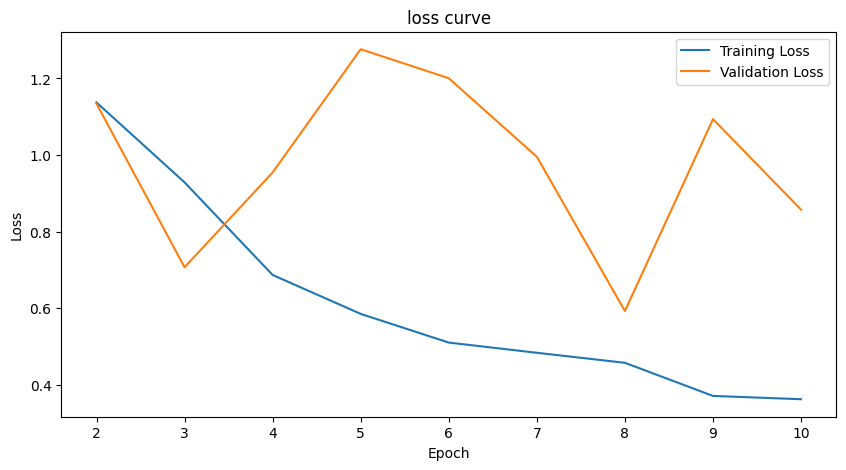

In [ ]:
loss_curve(10, train_losss, valid_losss)

In [ ]:
test_loss, test_accuracy=evall(model1, test_loader, losss)
print(f"Test loss:{test_loss},  Test accuracy:{test_accuracy}")

100%|██████████| 60/60 [00:28<00:00,  2.10it/s]

Test loss:0.32629487583634537,  Test accuracy:0.8833333253860474
